# Data Pre-processing

Note the system allow users to manually input sensor node informations. Therefore, step 1 is optional. For more details, see `STEP 1 - DATA GENERATION` part.

In [210]:
# import needed library
import pandas as pd
import numpy as np
import random
import math
import time
import csv
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as plb

from sklearn import preprocessing
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering

%matplotlib inline

# STEP 1 - DATA GENERATION (AUTOMATIC)

## 1.1. Set hyper-parameters

In [211]:
# the total number of sensor nodes
sensor_node_num = 1000

# maximum voltage of pressure sensors
p_v_max = 5.
# maximum voltage of temperature sensors
t_v_max = 2.5

# the scale of the square
scale_x_max = 300000
scale_y_max = 300000
# x and y coordinate of the origin point (Base Station)
origin_x = 150000                   
origin_y = 150000
# !!! NOTICE !!! the unit is [cm]

# Set seed for numpy.random according to current time
np.random.seed(np.int64(time.time()))

## 1.2. Functions of generating data

In [212]:
def generatePositions(max_sx, max_sy, ox, oy, num=1000):
    """
    Generate uniformly distributed x and y coordiantes of sensor nodes.
    
    Parameters
    ----------
    max_sx : scalar
        Maximum length of the grid (0 - 5 km)
        
    max_sy : scalar
        Maximum width of the grid (0 - 5km)
        
    ox : scalar
        X coordinate of the origin point
        
    ox : scalar
        Y coordinate of the origin point
    
    num : scalar
        Total number of sensor nodes
        
    Returns
    -------
    unique_locs : numpy.ndarray
        Array of point coordinates. Only unique pairs of point coordinates
        are allowed to avoid duplicates
    """
    
    # detect if input arguments out of range
    if max_sx > 500000 or max_sx < 0 or max_sy > 500000 or max_sy < 0:
        print('scale parameter cannot be negative or larger than 5 km !')
        return
    if ox > max_sx or ox < 0 or oy > max_sy or oy < 0:
        print('origin coordiante out of range !')
        return
    
    # keep looping until no duplicates
    dup_flag = True
    while dup_flag:
        xs = np.random.randint(0, max_sx + 1, num) - ox
        ys = np.random.randint(0, max_sy + 1, num) - oy
        locs = np.array([xs, ys], dtype='int').reshape(num, 2)
        dup_flag = False
        for i in range(num - 1):
            for j in range(i + 1, num):
                d = np.sqrt((xs[i]/100. - xs[j]/100.)**2 + (ys[i]/100. - ys[j]/100.)**2)
                if (d <= 1e-2):
                    dup_flag = True
                    break

    return locs


def generateFlags(num):
    """
    Generate equally uniformly distributed true and false flag to determine 
    types of sensor nodes.
    
    Parameters
    ----------
    num : scalar
        Total number of sensor nodes
        
    Returns
    -------
    p_flags : numpy.ndarray
        Array of sensor type flags
    """
    
    p_flags = []
    for _ in range(num):
        p_flags.append(random.sample(range(2),1))
    
    p_flags = np.array(p_flags).reshape(-1)
    
    return p_flags


def generateVolt(p):
    """
    Generate uniformly distributed voltage values according to sensor types.
    
    Parameters
    ----------
    p : logical
        Flag of sensor type. Allowed value: (True & False) or (0 & 1)
        
    Returns
    -------
    volt : scalar
        Voltage value
    """

    volt = 0.
    if p:
        volt = np.random.uniform(3., 5.)

    # Voltage range of temperature sensor is smaller
    else:
        volt = np.random.uniform(3., 5.) * 0.6

    return volt

def generateWeight(p, v):
    """
    Generate the weight value according to the difference between current
    voltage and maximum voltage of the sensor node.
    
    Parameters
    ----------
    p : logical
        Flag of sensor type. Allowed value: (True & False) or (0 & 1)
        
    v : scalar
        Voltage value
        
    Returns
    -------
    w : scalar
        Weight value range from 3 (low) to 10 (full)
    """
    
    vmax = 0.     # maximum voltage
    w = 0         # weight
    
    if p:
        vmax = p_v_max
    else:
        vmax = t_v_max
    
    if vmax - v <= 0.25: 
        w = 10
    elif vmax - v > 0.25 and vmax - v <= 0.5:  
        w = 9
    elif vmax - v > 0.5 and vmax - v <= 0.75:
        w = 8
    elif vmax - v > 0.75 and vmax - v <= 1.:
        w = 7
    elif vmax - v > 1. and vmax - v <= 1.25:
        w = 6
    elif vmax - v > 1.25 and vmax - v <= 1.5:
        w = 5
    elif vmax - v > 1.5 and vmax - v <= 1.75:
        w = 4
    else:
        w = 3
    
    return w


def generatePeriod(p):
    """
    Generate sense period time according to sensor type
    
    Parameters
    ----------
    p : logical
        Flag of sensor type. Allowed value: (True & False) or (0 & 1)
        
    Returns
    -------
    period : scalar
        Sense period time (second)
    """
    
    period = 0

    if p:
        period = 1
    else:
        period = 10
    
    return period

## 1.3. Ensemble in one function

In [213]:
def generateData(sx_max, sy_max, ox, oy, num):
    """
    Ensemble all data generation functions together
    
    Parameters
    ----------
    max_sx : scalar
        Maximum length of the grid (0 - 5 km)
        
    max_sy : scalar
        Maximum width of the grid (0 - 5km)
        
    ox : scalar
        X coordinate of the origin point
        
    ox : scalar
        Y coordinate of the origin point
    
    num : scalar
        Total number of sensor nodes    
    
    Returns
    -------
    points : numpy.ndarray
        Array of point coordinates. Only unique pairs of point coordinates
        are allowed to avoid duplicates
    
    flags : numpy.ndarray
        Array of sensor type flags
    
    volts : numpy.ndarray
        Array of stored voltages
    
    weights : numpy.ndarray
        Array of stored weights
    """
    
    points = generatePositions(sx_max, sy_max, ox, oy, num)
    flags = generateFlags(num)
    volts = []
    weights = []
    
    for _ in range(num):
        volts.append(generateVolt(flags[_]))
        weights.append(generateWeight(flags[_], volts[_]))
        
    volts = np.array(volts).reshape(-1)
    weights = np.array(weights).reshape(-1)
    
    return points, flags, volts, weights

## 1.4. Save data to CSV file

In [214]:
def saveDataCsv(num, fname='../input/inputs.csv', plot=False):
    """
    Save data to CSV file. Users can manually modify input CSV file
    to simulate wanted sensor node deployment and state.
    
    Parameters
    ----------
    num : scalar
        Total number of sensor nodes.
        
    plot : logical, optional
        If true, plot out sensor node deployment with corresponding weight.
        Default is False.
    """
    
    p_, f_, v_, w_ = generateData(scale_x_max, scale_y_max, origin_x, origin_y, num)

    # Comment below code if you don't want even number only here !
    cnt = 0
    last = -1
    for i in range(num):
        if f_[i]:
            if v_[i] <= 3.5:
                cnt += 1
                last = i
        else:
            if v_[i] <=  1.75:
                cnt += 1
                last = i

    if cnt % 2 != 0:
        v_[last] += 0.5
        print('The number of SNs to be recharged: %i'%(cnt-1))
    else:
        print('The number of SNs to be recharged: %i'%(cnt))
    # Comment above code if you don't want even number here !    

    with open(fname, 'w', newline='') as file:
        field_names = ['x_pos', 'y_pos', 'p_flag', 'volts', 'weights']
        writer = csv.DictWriter(file, fieldnames=field_names)     
        writer.writeheader()
        
        for _ in range(num):
            writer.writerow({'x_pos': p_[_][0], 'y_pos': p_[_][1], 
                            'p_flag':f_[_], 'volts': v_[_], 'weights': w_[_]})
            
    if plot:
        fig = plt.subplots(figsize=(20, 16))
        ax = plt.axes()
        plt.scatter(p_[:, 0], p_[:, 1], c=w_)
        plt.colorbar()
        plt.xlabel('X coordinate [dm]', fontsize=18)
        plt.ylabel('Y coordinate [dm]', fontsize=18)
        plt.title ('Deployment of sensor nodes', fontsize=22)

The number of SNs to be recharged: 128


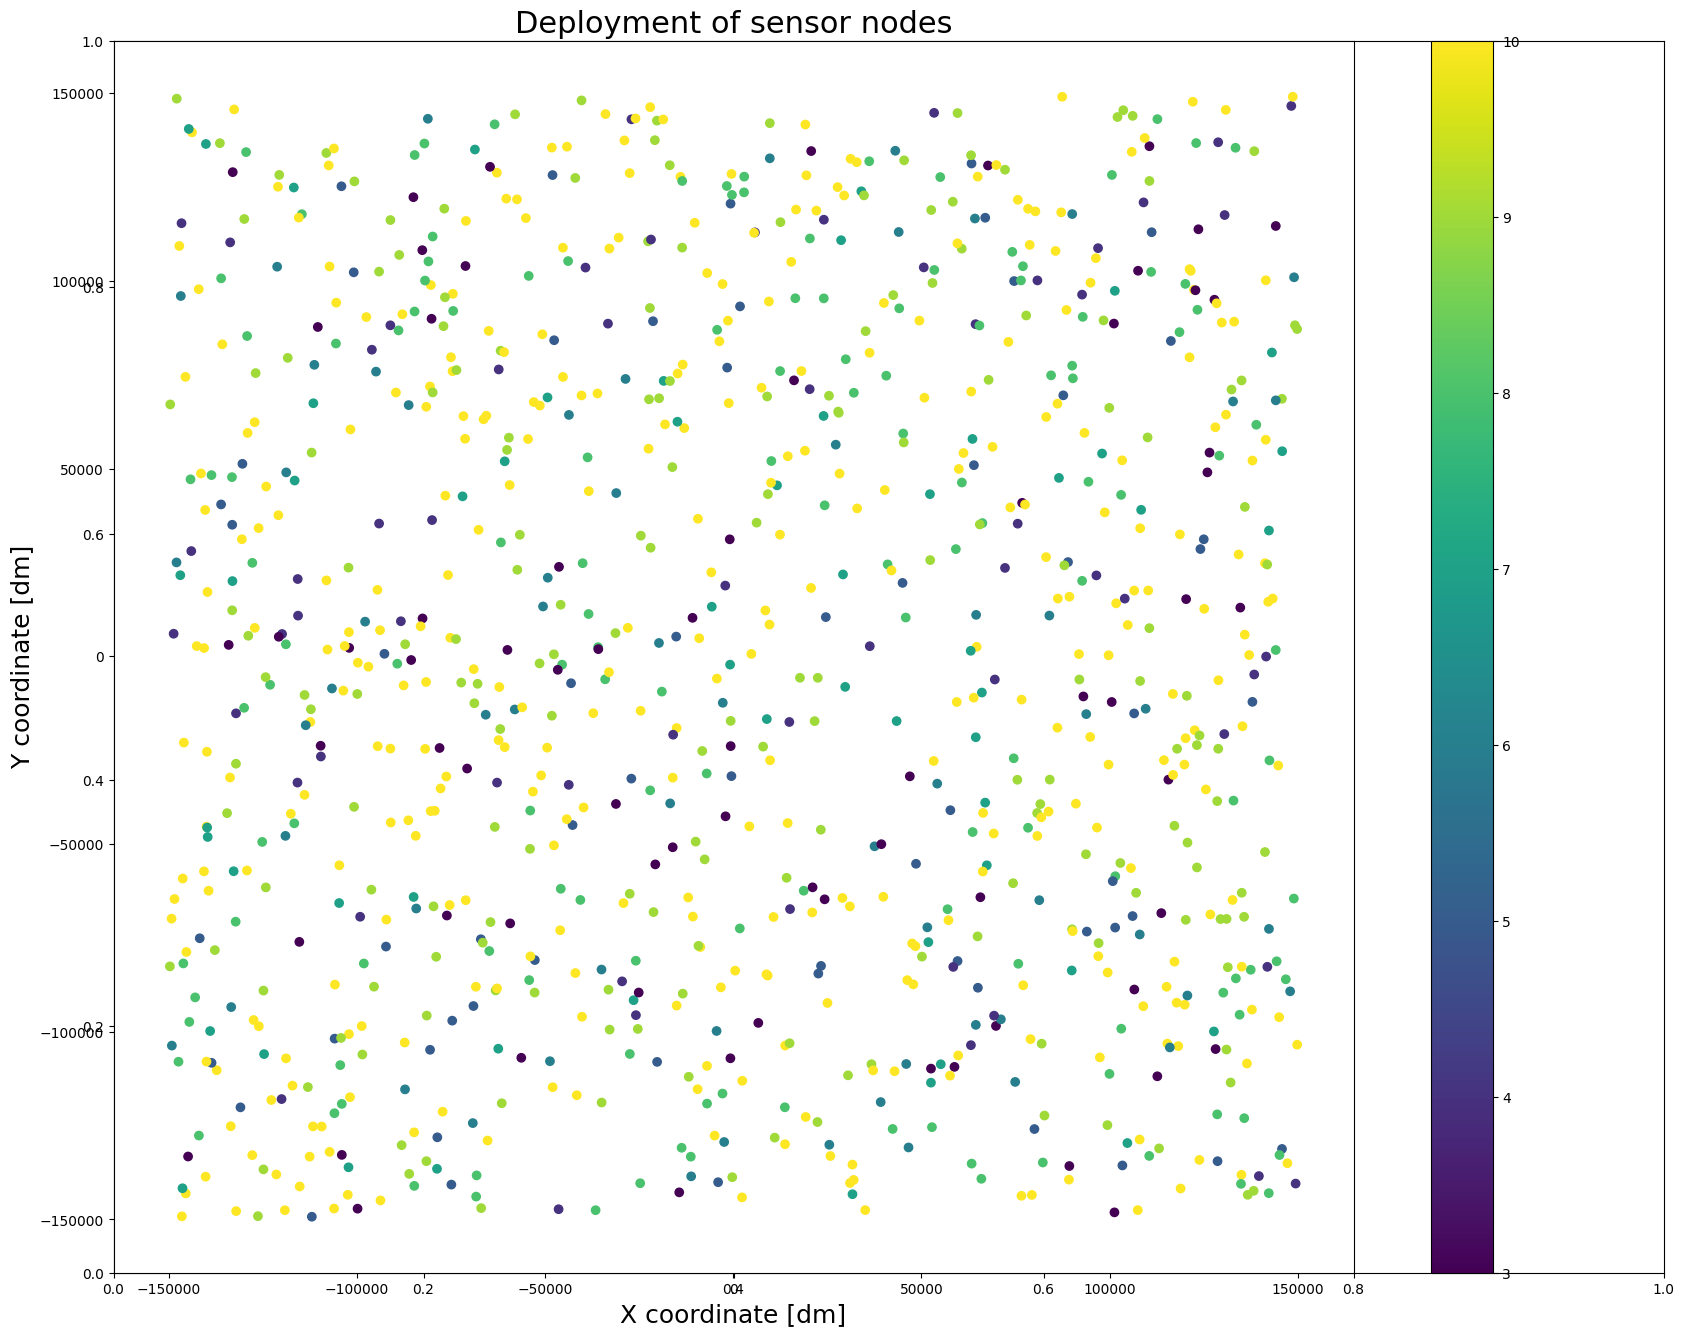

In [215]:
saveDataCsv(sensor_node_num, plot=True)

---

# OPTIONAL STEP - PATH ASSIGNMENT (UNSUPERVISED CLUSTERING)

Using following code to cluster SNs to be recharged with K-Means, Spectral or Agglomerative Clustering. Then users can use `pdv_simulation` code to see recharging situations (to compare with GA, BH and SA).

***!!! NOTICE !!! In this section, below file is needed:***  
Input CSV file with same format as the one generated by `STEP 1 - DATA GENERATION` part

## 2.1. Set hyper-parameters

In [216]:
# Set seed for numpy.random according to current time
seed = np.int64(time.time())
np.random.seed(seed)

# Maximum allowed number of charged sensor node in the task list
pdv_max_charge_num = 40
# Minimum allowed number of charged sensor node in the task list
pdv_min_charge_num = 18
# All sensor node information stored in `inputs.csv`
input_data_path = "../input/inputs.csv"

## 2.2. Load data

The number of SNs to be recharged: 128


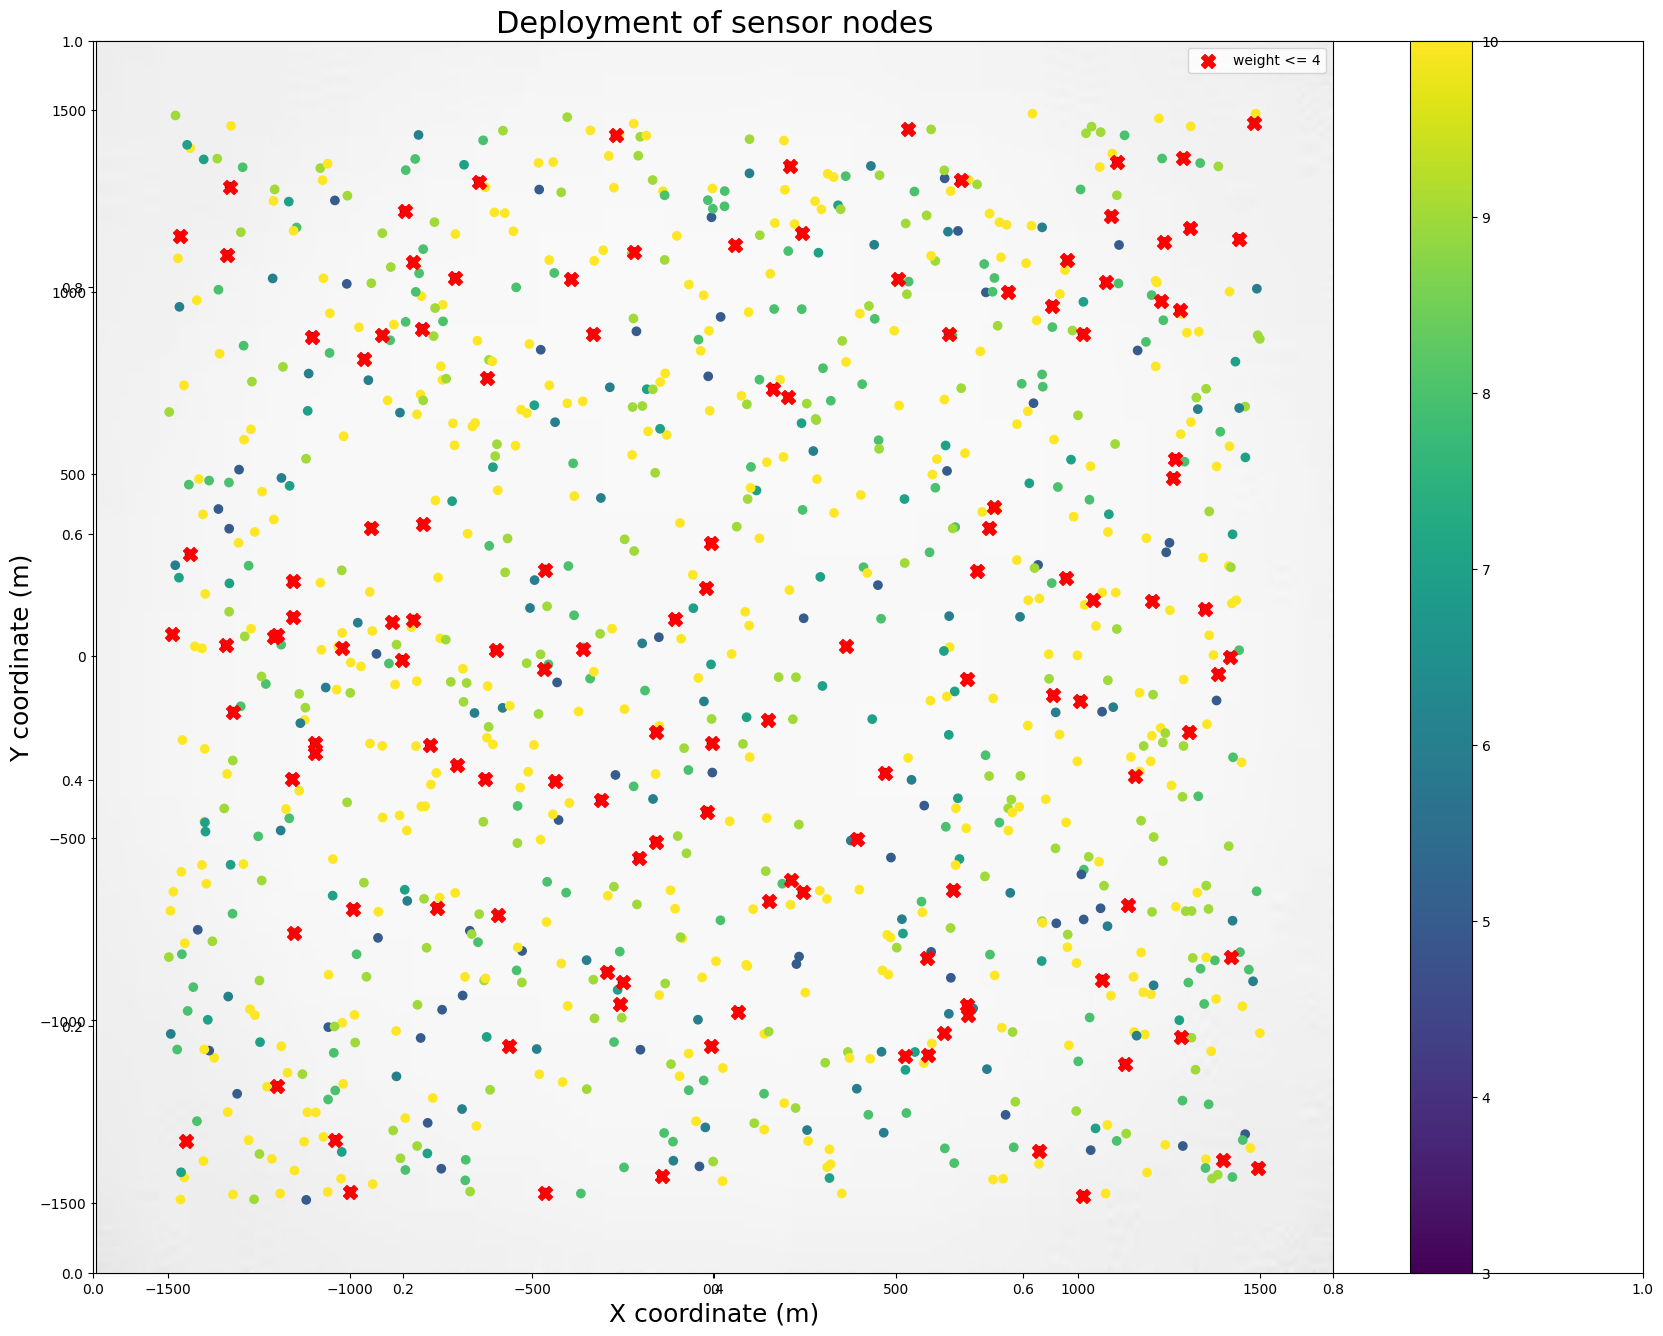

In [217]:
def loadData(in_path="../input/inputs.csv", plot=False):
    """
    Load all needed data from CSV files, and plot it out.
    
    Parameters
    ----------
    in_path : string, optional
        All sensor nodes file path. Default is "../input/inputs.csv".
        
    plot : logical, optional
        If true, plot out sensor node deployment with corresponding weight. Default is false.
        
    Returns
    -------
    num_xs : scalar
        The number of sensor nodes
        
    xs : numpy.ndarray
        2D array of points in flight path 
    """

    input_data = pd.read_csv(in_path)
    req_xs = input_data['x_pos'][input_data['weights'] <= 4].to_numpy() / 100.
    req_ys = input_data['y_pos'][input_data['weights'] <= 4].to_numpy() / 100.
    limit = (input_data['x_pos'].min() / 100. - 200, input_data['x_pos'].max() / 100. + 200,
            input_data['y_pos'].min() / 100. - 200, input_data['y_pos'].max() / 100. + 200)

    # Please note that it is NOT accurate to check the number of SNs to be recharged
    # throught 'weights' factor, but we can roughly check if it's acceptable.
    print('The number of SNs to be recharged: %i'%(req_xs.shape[0]))
    
    if plot:
        c_min = np.min(input_data['weights'].to_numpy())
        c_max = np.max(input_data['weights'].to_numpy())
        fig = plt.subplots(figsize=(20, 16))
        ax = plt.axes()
        fig1 = plt.imread('../output/farm.jpeg')
        plt.scatter(input_data['x_pos'].to_numpy() / 100., 
                    input_data['y_pos'].to_numpy()/ 100., 
                    c=input_data['weights'].to_numpy())
        plt.scatter(req_xs, req_ys, c='r', s=100, marker='X', label='weight <= 4')
        plt.imshow(fig1, zorder=0, extent=limit, aspect='equal')
        plt.xlabel('X coordinate (m)', fontsize=18)
        plt.ylabel('Y coordinate (m)', fontsize=18)
        plt.title ('Deployment of sensor nodes', fontsize=22)
        plt.clim(c_min, c_max)
        plt.legend()
        plt.colorbar()
        plt.show()
        
    ps = np.zeros((req_xs.shape[0], 2), dtype=np.float32) 
    ps[:, 0] = req_xs
    ps[:, 1] = req_ys
    num_ps = ps.shape[0]
    return num_ps, ps

num_sns, sns = loadData(input_data_path, plot=True)

## 2.3. Prepartion work for clustering

In [218]:
def gridSearch(num_sn, min_charge_num=18, max_charge_num=40):
    """
    Calculate the appropriate range of PDV numbers (clusters)
    
        
    Parameters
    ----------
    num_sn : scalar
        Total number of sensor nodes
        
    min_charge_num : scalar, optional
        The minimum number of sensor nodes to charge.
        Default is 18.
    
    max_charge_num : scalar, optional
        The maximum number of sensor nodes to charge.
        Default is 40.
        
    Returns
    -------
    num_list : list
        The list of cluster numbers
    """
    
    min_num_pdv = int(math.floor(num_sn / max_charge_num))
    max_num_pdv = int(math.floor(num_sn / min_charge_num))
    num_list = []
    for i in range(min_num_pdv, max_num_pdv + 1):
        if i: 
            num_list.append(i)

    return num_list

# Uncomment below code to see the number of clusters to be clustered later
# num_sns, sns = loadData(in_path=input_data_path, plot=true) 
# gridSearch(num_sns, pdv_min_charge_num, pdv_max_charge_num)

In [219]:
class Point:
    """
    The class called Point, which is used to store 2D data (x and y coordinate).
    """

    def __init__(self, x, y):
        """
        Set the attribute x and y.

        Paramters
        ---------
        x : scalar
            x coordinate value

        y : scalar
            y coordinate value
        """
        
        self.x = x
        self.y = y

    def calcDistance(self, x2, y2):
        """
        Calculate distance between two points

        Paramters
        ---------
        x2 : scalar
            x coordinate value of the other point

        y2 : scalar
            y coordinate value of the other point

        Returns
        _______
        d : scalar
            Distance between two points
        """

        d = np.sqrt((self.x - x2)**2 + (self.y - y2)**2)
        return d
    
    def calcAngle(self):
        """
        Calculate angle (ONLY USED IN SINGLE QUADRANT CASE).

        Returns
        -------
        angle : scalar
            angle (radian)
        """

        angle = np.arctan(self.x / self.y)
        return angle

In [220]:
def convertArrayToPoints(array):
    """
    Convert array of Point objects to 2D list
    
    Paramters
    ---------
    array : numpy.ndarray
        An array of Point objects to be calculated
    
    Returns
    -------
    path : list
        2D list of point information (x and y)
    
    """
    
    path = []
    for i in range(array.shape[0]):
        path.append(Point(array[i][0], array[i][1]))
    return path    
    
def calcDistances(array):
    """
    For an array of Point objects, traverse all points (starting  
    from the origin and returning to the origin)
    
    Parameters
    ----------
    array : numpy.ndarray
        An array of Point objects to be calculated.
    
    Returns
    -------
    total_d : scalar
        Total distance
    """    
    
    p1 = Point(0, 0)
    total_d = 0
    path = convertArrayToPoints(array)
    # Leave one for return to home process
    while len(path) != 1:   
        next_index = 0
        temp_d = p1.calcDistance(path[next_index].x, path[next_index].y)
        for i in range(1, len(path)):
            curr_d = p1.calcDistance(path[i].x, path[i].y)
            if curr_d < temp_d:
                temp_d = curr_d
                next_index = i
            
        p1 = Point(path[next_index].x, path[next_index].y)
        del path[next_index]
        total_d += temp_d
        
    total_d += path[0].calcDistance(0, 0)
    return total_d

def calcAngleWeights(num, array):
    """
    Calculate related weight according to angle of the point. 
    (ONLY USED IN SINGLE QUADRANT CASE CALCULATION)
    
    Parameters
    ----------
    num : scalar
        Divide `num` weight parts equally.
        
    array : numpy.ndarray    
        An array of Point objects to be calculated.
        
    Returns
    -------
    total_d : scalar
        Total distance
    """
    
    path = convertArrayToPoints(array)
    angles = []
    for i in range(len(path)):
        angles.append(path[i].calcAngle())
    
    # Can choose two ways to preprocess data
    # Standardlization 
    std_deg = np.std(angles)
    mean_deg = np.mean(angles)
    for i in range(len(angles)):
        angles[i] = (angles[i] - mean_deg) / std_deg
        
    # Normalization
#     max_deg = np.max(angles)
#     min_deg = np.min(angles)
#     for i in range(len(angles)):
#         angles[i] = (angles[i] - min_deg) / (max_deg - min_deg)
        
        # In for loop, we can form weight to int from 1 to `num`,
        # but no results shows better clustering effect
#         print(angles[i])
#         angles[i] = int(angles[i])
#         if angles[i] <= 1. / num:
#             angles[i] = 1. /num
#         elif angles[i] > float((num - 1) / num):
#             angles[i] = 1.
#         else:
#             angles[i] = angles[i]

    return angles

## 2.4. Clustering strategy

***!!! NOTICE !!! For all clustering strategies, only single BS was considered.*** 

The total flight distance is calculated through Shortest Job Next (SJN) strategy, which finds the nearest neighbour as next flight target. Note that the PDV should take off from the BS at the beginning and return to the BS finally.

### 2.4.1. (Weighted) K-Means Clustering

In [221]:
def wtKMeansClustering(in_path, min_charge_num=18, max_charge_num=40,
                        seed=42, plot=False):
    """
    Apply K-Means Clustering to complete flight path points. Please note that
    the angle weight can be applied to sklearn weighted K-Means Clustering.
    But no better results were shown. See 
    https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    for more information.
    
    Parameters
    ----------
    in_path : string
        All sensor nodes file path.
        
    min_charge_num : scalar, optional
        The minimum number of sensor nodes to charge.
        Default is 18.
    
    max_charge_num : scalar, optional
        The maximum number of sensor nodes to charge.
        Default is 40.
        
    seed : scalar
        The seed of random state.
        Default is 42.
        
    plot : logical, optional
        If True, plot out all clustering results.
        Default is False.
        
    Returns
    -------
    all_sub_paths : list
        List of zipped path (including all clustering solutions)
    """
    
    num_sns, sns = loadData(in_path)
    cluster = gridSearch(num_sns, min_charge_num, max_charge_num)
    all_sub_paths = []
    # Plot some degrees
#     xx = np.linspace(0, 2000, 1000)
#     yy = np.linspace(0, 2000, 1000)
#     for i in range(len(angles)-100):
#         plt.scatter(sns[i, 0], sns[i, 1], label='%i %i %i'%(angles[i], sns[i, 0], sns[i, 1]))
#         plt.plot(xx, yy)
#         plt.legend()
#         plt.show()
    
    # traverse all options 
    for c in cluster:
        # Calculate angles for each point
#         angles = calcAngleWeights(c, sns)

        total_cost = 0
        clf = KMeans(n_clusters=c, random_state=seed)
        
        # use `sample_weight=angles` in the below command to apply weighted clustering
        labels = clf.fit_predict(sns)
        
        sub_paths = []
        work_flag = True
        for _ in range(c):
            # The number of assigned sensor nodes must not exceed `max_charge_num`
            # If exceed, break the loop
            if np.count_nonzero(labels == _) > max_charge_num:
                work_flag = False
                print('For %i Clusters, the PDV %i cannot complete Weighted KMeans Clustering !\nEnd calculation ! No path stored !'%(c, _))
                print('\n')
                break
            else:   
                sp = [sns[labels == _, 0], sns[labels == _, 1]]
                sub_paths.append(sp)
                cost = calcDistances(np.array(sp))
                print('For %i Clusters, the PDV %i, the flight distance is %.2f m' %(c, _, cost))
                total_cost += cost
        
        if not work_flag:
            continue
        else:
            sub_zip = list(zip(sub_paths))
            all_sub_paths.append(sub_zip)
            print('For %i clusters, the total flight path is %.2f m' %(c, total_cost))

            if plot:
                fig = plt.subplots(figsize=(10, 8))
                ax = plt.axes()
                mat = plt.scatter(sns[:, 0], sns[:, 1], c=labels)
                for i in range(len(clf.cluster_centers_[:, 0])):
                    plt.scatter(clf.cluster_centers_[i, 0], clf.cluster_centers_[i, 1], 
                                marker="*", label='Centre %i' % i)
                cax = plt.colorbar(mat, ticks=np.arange(0, np.max(labels)+1))
                plt.xlabel('X Coordiante (m)', fontsize=16)
                plt.ylabel('Y Coordiante (m)', fontsize=16)
                plt.title ('Result of (Weighted) K-Means Clustering', fontsize=16)
                plt.legend()
                plt.show()
            
            print("\n")
        
    return all_sub_paths

The number of SNs to be recharged: 128
For 3 Clusters, the PDV 0, the flight distance is 2812.08 m
For 3 Clusters, the PDV 1, the flight distance is 2131.81 m
For 3 Clusters, the PDV 2 cannot complete Weighted KMeans Clustering !
End calculation ! No path stored !


For 4 Clusters, the PDV 0, the flight distance is 2355.52 m
For 4 Clusters, the PDV 1, the flight distance is 1541.49 m
For 4 Clusters, the PDV 2, the flight distance is 1735.22 m
For 4 Clusters, the PDV 3, the flight distance is 2793.23 m
For 4 clusters, the total flight path is 8425.47 m


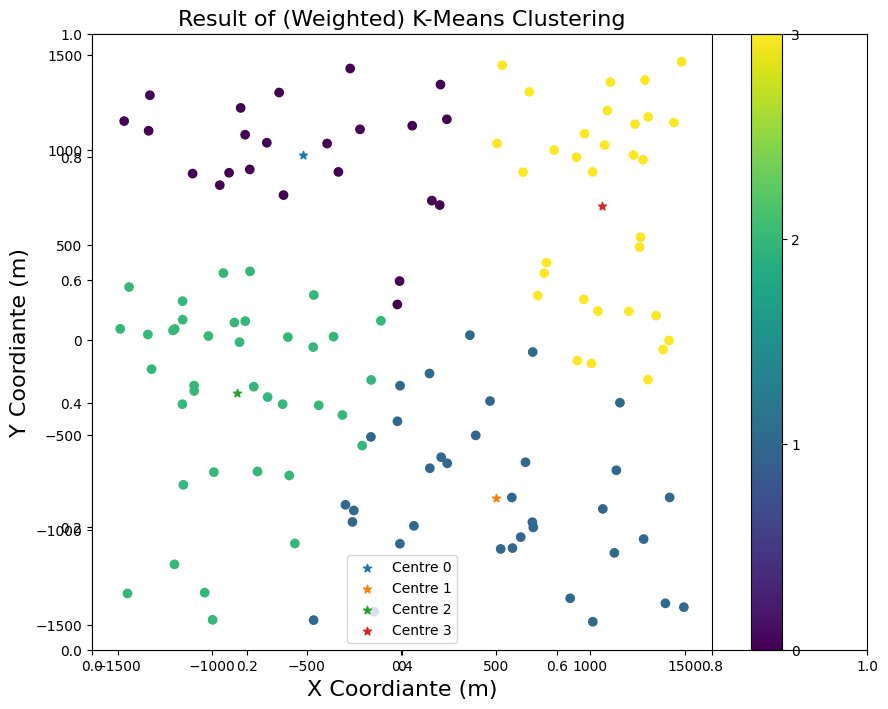



For 5 Clusters, the PDV 0, the flight distance is 2355.52 m
For 5 Clusters, the PDV 1, the flight distance is 1174.47 m
For 5 Clusters, the PDV 2, the flight distance is 1735.22 m
For 5 Clusters, the PDV 3, the flight distance is 2131.81 m
For 5 Clusters, the PDV 4, the flight distance is 2812.08 m
For 5 clusters, the total flight path is 10209.10 m


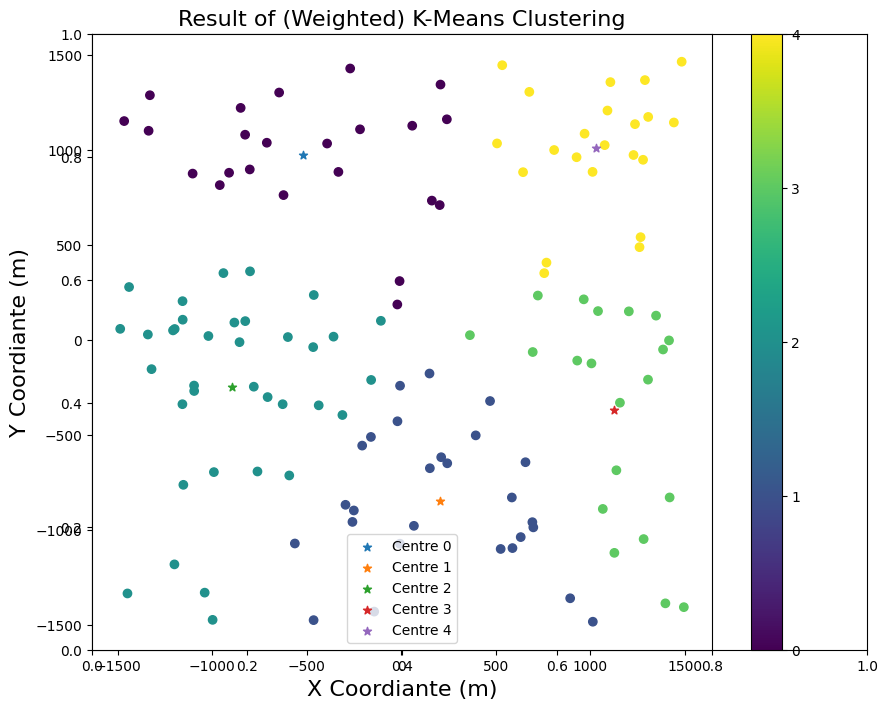



For 6 Clusters, the PDV 0, the flight distance is 2355.52 m
For 6 Clusters, the PDV 1, the flight distance is 2867.38 m
For 6 Clusters, the PDV 2, the flight distance is 1400.64 m
For 6 Clusters, the PDV 3, the flight distance is 2131.81 m
For 6 Clusters, the PDV 4, the flight distance is 2812.08 m
For 6 Clusters, the PDV 5, the flight distance is 1878.53 m
For 6 clusters, the total flight path is 13445.96 m


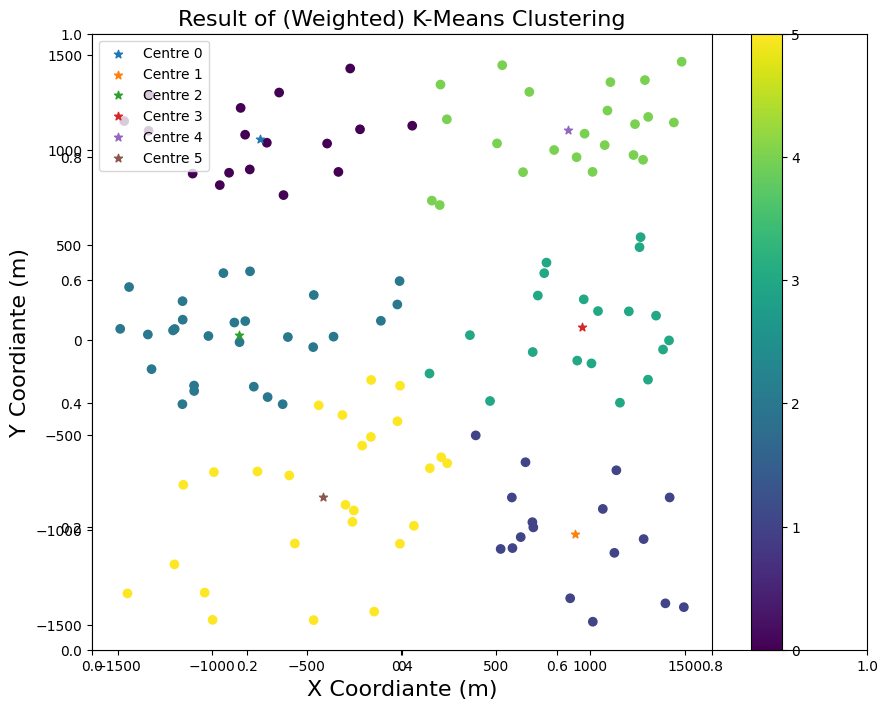



For 7 Clusters, the PDV 0, the flight distance is 2355.52 m
For 7 Clusters, the PDV 1, the flight distance is 2867.38 m
For 7 Clusters, the PDV 2, the flight distance is 1400.64 m
For 7 Clusters, the PDV 3, the flight distance is 2131.81 m
For 7 Clusters, the PDV 4, the flight distance is 2812.08 m
For 7 Clusters, the PDV 5, the flight distance is 1878.53 m
For 7 Clusters, the PDV 6, the flight distance is 790.35 m
For 7 clusters, the total flight path is 14236.31 m


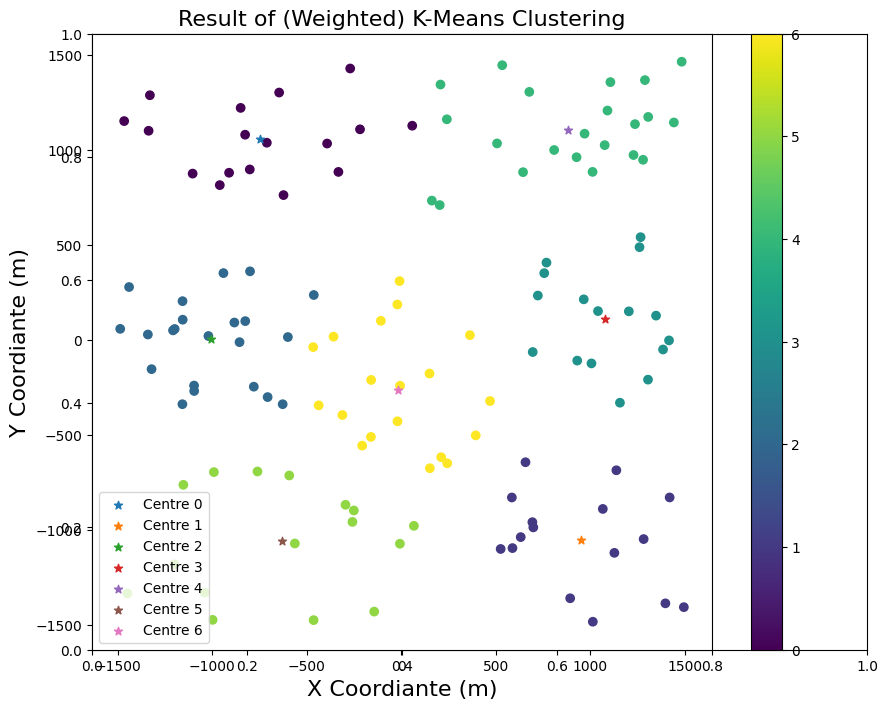

In [222]:
all_p_km = wtKMeansClustering(input_data_path, seed=seed, plot=True)

### 2.4.2. Spectral Clustering

In [223]:
def spectralClustering(in_path, min_charge_num=20, 
                       max_charge_num=40, seed=42, plot=False):
    """
    Apply Spectral Clustering to complete flight path points. An average
    number of neigbours will be calculated in advance to give the model 
    an inital value. See 
    https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html
    for more information.
    
    Parameters
    ----------
    in_path : string
        All sensor nodes file path.

    min_charge_num : scalar, optional
        The minimum number of sensor nodes to charge.
        Default is 18.
    
    max_charge_num : scalar, optional
        The maximum number of sensor nodes to charge.
        Default is 40.
    
    seed : scalar
        The seed of random state.
        Default is 42.
    
    plot : logical, optional
        If True, plot out all clustering results.
        Default is False.
        
    Returns
    -------
    all_sub_paths : list
        List of zipped path (including all clustering solutions)
    """
    
    average_num = int((min_charge_num + max_charge_num) / 2)
    num_sns, sns = loadData(in_path)
    cluster = gridSearch(num_sns, min_charge_num, max_charge_num)
    all_sub_paths = []
    
    for c in cluster:
        total_cost = 0
        average_num = (sns.shape[0], average_num)[average_num < sns.shape[0]]
        clf = SpectralClustering(n_clusters=c, affinity='nearest_neighbors',
                                 n_neighbors=average_num,
                                 random_state=seed)
        labels = clf.fit_predict(sns)    
        
        sub_paths = []
        work_flag = True
        
        for _ in range(c):
            if np.count_nonzero(labels == _) > max_charge_num:
                work_flag = False
                print('For %i Clusters, the PDV %i cannot complete Spectral Clustering !\nEnd calculation ! No path stored !'%(c, _))
                print('\n')
                break
            else:   
                sp = [sns[labels == _, 0], sns[labels == _, 1]]
                sub_paths.append(sp)
                cost = calcDistances(np.array(sp))
                print('For %i Clusters, the PDV %i, the flight distance is %.2f m' %(c, _, cost))
                total_cost += cost

        if not work_flag:
            continue
        else:
            sub_zip = list(zip(sub_paths))
            all_sub_paths.append(sub_zip)
            print('For %i clusters, the total flight path is %.2f m' %(c, total_cost))

            if plot:
                fig = plt.subplots(figsize=(10, 8))
                ax = plt.axes()
                mat = plt.scatter(sns[:, 0], sns[:, 1], c=labels)
                cax = plt.colorbar(mat, ticks=np.arange(0, np.max(labels)+1))
                plt.xlabel('X Coordiante (m)', fontsize=16)
                plt.ylabel('Y Coordiante (m)', fontsize=16)
                plt.title ('Result of Spectral Clustering', fontsize=16)
                plt.show()
            
            print("\n")
        
    return all_sub_paths

The number of SNs to be recharged: 128
For 3 Clusters, the PDV 0, the flight distance is 2812.08 m
For 3 Clusters, the PDV 1 cannot complete Spectral Clustering !
End calculation ! No path stored !


For 4 Clusters, the PDV 0, the flight distance is 1422.67 m
For 4 Clusters, the PDV 1, the flight distance is 1961.34 m
For 4 Clusters, the PDV 2, the flight distance is 2812.08 m
For 4 Clusters, the PDV 3, the flight distance is 2131.81 m
For 4 clusters, the total flight path is 8327.90 m


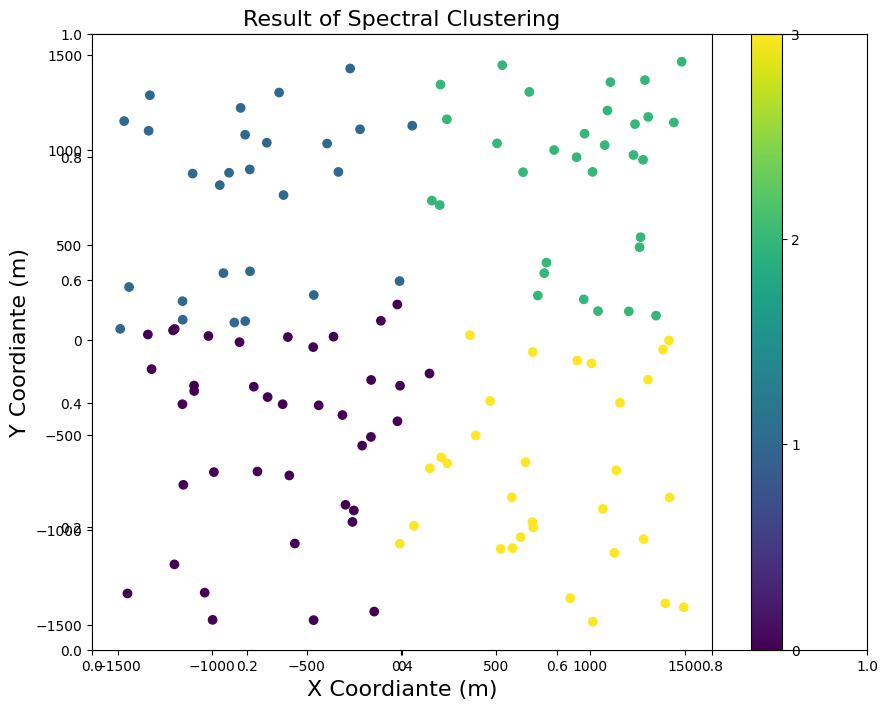



For 5 Clusters, the PDV 0, the flight distance is 2812.08 m
For 5 Clusters, the PDV 1, the flight distance is 1400.64 m
For 5 Clusters, the PDV 2, the flight distance is 1407.02 m
For 5 Clusters, the PDV 3, the flight distance is 2131.81 m
For 5 Clusters, the PDV 4, the flight distance is 2355.52 m
For 5 clusters, the total flight path is 10107.08 m


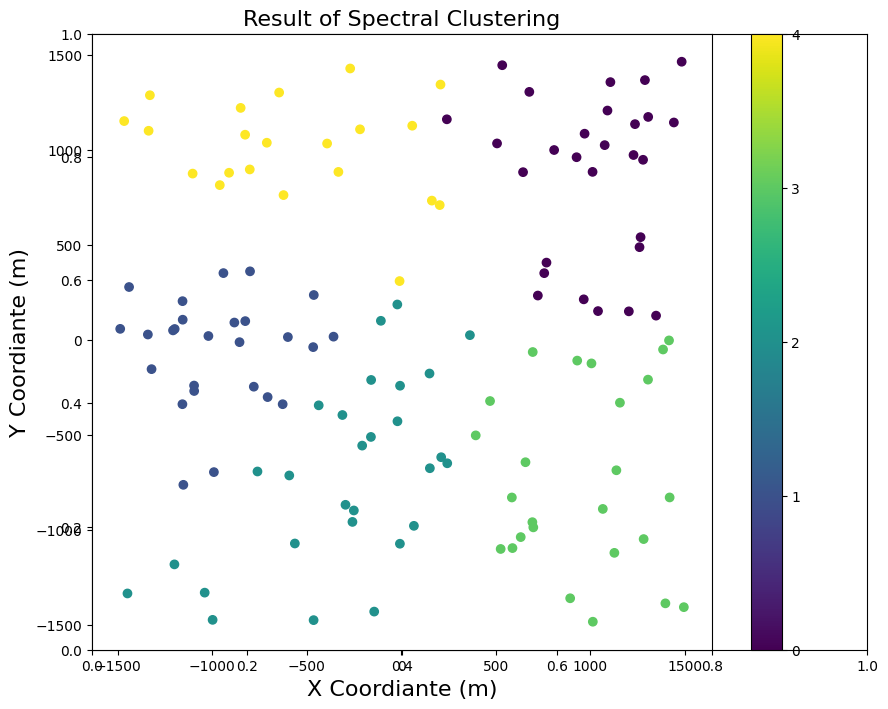



For 6 Clusters, the PDV 0, the flight distance is 2812.08 m
For 6 Clusters, the PDV 1, the flight distance is 1878.53 m
For 6 Clusters, the PDV 2, the flight distance is 2355.52 m
For 6 Clusters, the PDV 3, the flight distance is 1400.64 m
For 6 Clusters, the PDV 4, the flight distance is 790.35 m
For 6 Clusters, the PDV 5, the flight distance is 2131.81 m
For 6 clusters, the total flight path is 11368.93 m


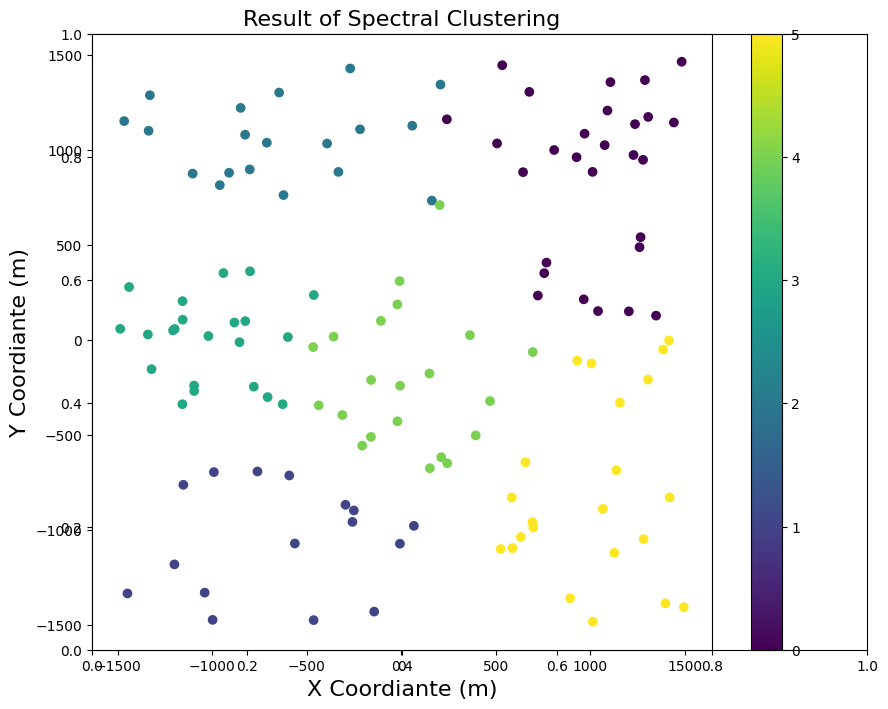

In [224]:
all_p_spe = spectralClustering(input_data_path, seed=seed, plot=True)

### 2.4.3. Agglomerative Clustering

In [225]:
def agglomerativeClustering(in_path, min_charge_num=20, max_charge_num=40, 
                            seed=42, plot=False):
    """
    Apply Spectral Clustering to complete flight path points. An average
    number of neigbours will be calculated in advance to give the model 
    an inital value. More parameters will be tuned in the future. See 
    https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
    for more details.
    
    Parameters
    ----------
    in_path : string
        All sensor nodes file path.
        
    min_charge_num : scalar, optional
        The minimum number of sensor nodes to charge.
        Default is 18.
    
    max_charge_num : scalar, optional
        The maximum number of sensor nodes to charge.
        Default is 40.
    
    seed : scalar
        The seed of random state.
        Default is 42.
    
    plot : logical, optional
        If True, plot out all clustering results.
        Default is False.
        
    Returns
    -------
    all_sub_paths : list
        List of zipped path (including all clustering solutions)
    """
    
    average_num = int((min_charge_num + max_charge_num) / 2)
    num_sns, sns = loadData(in_path)
    cluster = gridSearch(num_sns, min_charge_num, max_charge_num)
    knn_graph = kneighbors_graph(sns, average_num, include_self=True)
    all_sub_paths = []
    
    for c in cluster:
        total_cost = 0
        
        clf = AgglomerativeClustering(n_clusters=c, 
                                      connectivity=knn_graph,
                                      linkage="ward")
        labels = clf.fit_predict(sns)    
        
        sub_paths = []
        work_flag = True
        
        for _ in range(c):
            if np.count_nonzero(labels == _) > max_charge_num:
                work_flag = False
                print('For %i Clusters, the PDV %i cannot complete Agglomerative Clustering !\nEnd calculation ! No path stored !'%(c, _))
                print('\n')
                break
            else:   
                sp = [sns[labels == _, 0], sns[labels == _, 1]]
                sub_paths.append(sp)
                cost = calcDistances(np.array(sp))
                print('For %i Clusters, the PDV %i, the flight distance is %.2f m' %(c, _, cost))
                total_cost += cost

        if not work_flag:
            continue
        else:
            sub_zip = list(zip(sub_paths))
            all_sub_paths.append(sub_zip)
            print('For %i clusters, the total flight path is %.2f m' %(c, total_cost))

            if plot:
                fig = plt.subplots(figsize=(10, 8))
                ax = plt.axes()
                mat = plt.scatter(sns[:, 0], sns[:, 1], c=labels)
                cax = plt.colorbar(mat, ticks=np.arange(0, np.max(labels)+1))
                plt.xlabel('X Coordiante (m)', fontsize=16)
                plt.ylabel('Y Coordiante (m)', fontsize=16)
                plt.title ('Result of Agglomerative Clustering', fontsize=16)
                plt.show()
            
            print("\n")
        
    return all_sub_paths

The number of SNs to be recharged: 128
For 3 Clusters, the PDV 0 cannot complete Agglomerative Clustering !
End calculation ! No path stored !


For 4 Clusters, the PDV 0 cannot complete Agglomerative Clustering !
End calculation ! No path stored !


For 5 Clusters, the PDV 0, the flight distance is 2793.23 m
For 5 Clusters, the PDV 1, the flight distance is 1433.79 m
For 5 Clusters, the PDV 2, the flight distance is 2867.38 m
For 5 Clusters, the PDV 3, the flight distance is 2355.52 m
For 5 Clusters, the PDV 4, the flight distance is 1735.22 m
For 5 clusters, the total flight path is 11185.14 m


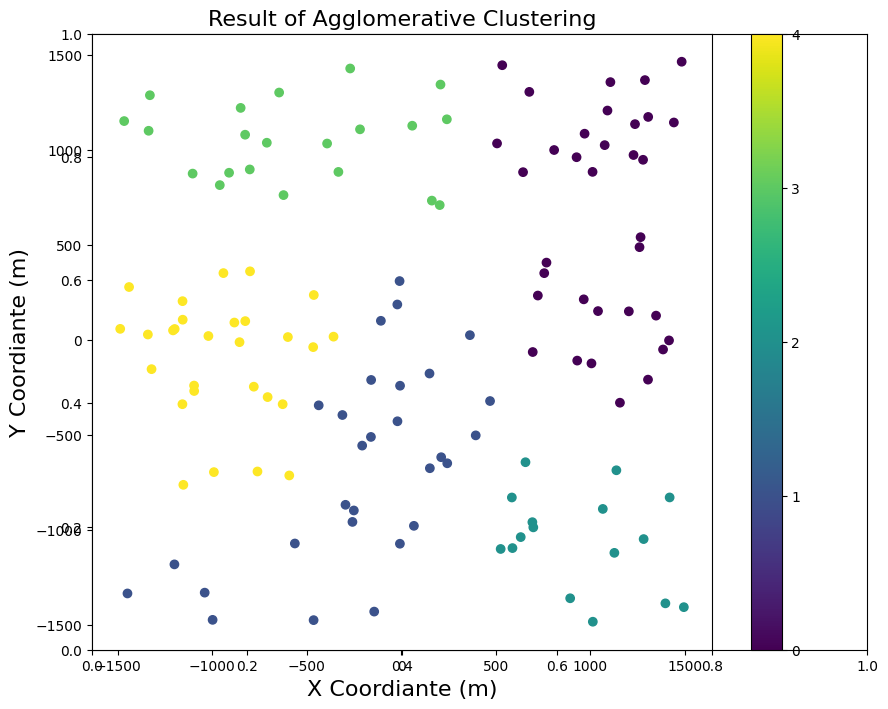



For 6 Clusters, the PDV 0, the flight distance is 1433.79 m
For 6 Clusters, the PDV 1, the flight distance is 2355.52 m
For 6 Clusters, the PDV 2, the flight distance is 2867.38 m
For 6 Clusters, the PDV 3, the flight distance is 2812.08 m
For 6 Clusters, the PDV 4, the flight distance is 1735.22 m
For 6 Clusters, the PDV 5, the flight distance is 2131.81 m
For 6 clusters, the total flight path is 13335.80 m


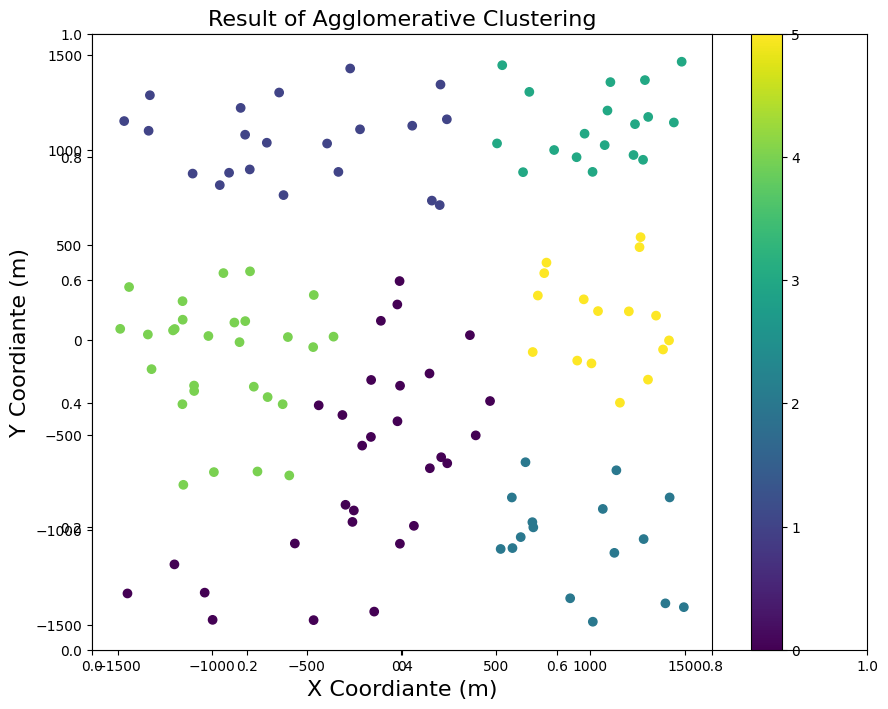

In [226]:
all_p_agg = agglomerativeClustering(input_data_path, plot=True)

## 2.5. Performance Analysis

Users **SHOULD** compare the results and choose the output data manually. Otherwise, the best result of K-Means Clustering will be the output. Here K-Means Clustering shows the best result (shortest flight distance for all PDVs).

In [227]:
# Final output path can be checked through following format
# print(all_p_km[0])

## 2.6. Output data

In [228]:
def convertZipToArrays(data):
    """
    Zip format is hard to be written to CSV file.
    Extract the data out.
    
    Parameters
    ----------
    data : list
        A list of zipped data
    
    Returns
    -------
    sub_path : list
        A list of numpy.ndarray
    """
    
    sub_path = []
    for item in data:
        for sub_item in item:
            sub_path.append(np.array([sub_item[0], sub_item[1]], dtype=np.float32))
            
    return sub_path

def saveDataCsv(data, out_path="../input"):
    """
    Save all sub paths to different CSV files
    
    Parameters
    ----------
    data : list
        A list of zipped data
        
    out_path : string, optional
        The folder path to store files. Default is "../input".
    """
    
    final = convertZipToArrays(data)
    for i in range(len(final)):
        path = out_path + "/sub_path" + str(i) + ".csv"
        with open(path, 'w', newline='') as file:
            field_names = ['x_pos', 'y_pos']
            writer = csv.DictWriter(file, fieldnames=field_names)
            writer.writeheader()

            for _ in range(final[i].shape[1]):
                writer.writerow({'x_pos': final[i][0][_], 'y_pos': final[i][1][_]})

In [229]:
saveDataCsv(all_p_km[0])